<a href="https://colab.research.google.com/github/drthaodao3101/Multi5VocalFolds/blob/master/Torch_InceptionV3_Multi5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import listdir

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset  # For custom datasets

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import transforms

import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
from PIL import Image

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir /content/data
!unzip "/content/drive/MyDrive/Multi5Class_VC/Data/Train.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/Multi5Class_VC/Data/Train.zip
  inflating: /content/data/Train/20191010151023.jpg  
  inflating: /content/data/Train/20191010151026.jpg  
  inflating: /content/data/Train/20191010151054.jpg  
  inflating: /content/data/Train/20191010151059.jpg  
  inflating: /content/data/Train/20191105090148.jpg  
  inflating: /content/data/Train/20200207145703.jpg  
  inflating: /content/data/Train/20200210083159.jpg  
  inflating: /content/data/Train/20200210083200.jpg  
  inflating: /content/data/Train/20200213085258.jpg  
  inflating: /content/data/Train/20200221095700.jpg  
  inflating: /content/data/Train/20200221095712.jpg  
  inflating: /content/data/Train/20200224152025.jpg  
  inflating: /content/data/Train/20200228091101.jpg  
  inflating: /content/data/Train/20200228091104.jpg  
  inflating: /content/data/Train/20200304140844.jpg  
  inflating: /content/data/Train/20200304140926.jpg  
  inflating: /content/data/Train/20200304140942.jpg  
  inflating: /conte

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Multi5Class_VC/Data/output.csv',sep=',', header=None)
df.columns = ['image','label']

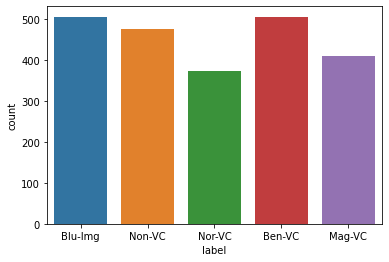

In [7]:
ax = sns.countplot(x="label", data=df, order=['Blu-Img','Non-VC','Nor-VC','Ben-VC','Mag-VC'])

In [8]:
#df.shape[0]
df['label'].value_counts()

Ben-VC     506
Blu-Img    505
Non-VC     475
Mag-VC     410
Nor-VC     374
Name: label, dtype: int64

In [9]:
idx = int(df.shape[0]*0.2)
idx

454

In [10]:
df.head()

,image,label
0,20191105090148.jpg,Blu-Img
1,20200207145703.jpg,Blu-Img
2,20200213085258.jpg,Blu-Img
3,20200221095712.jpg,Blu-Img
4,20200221095700.jpg,Blu-Img


In [11]:
df = df.sample(frac=1,random_state=42).reset_index(drop=True)

In [12]:
df

,image,label
0,20201215094209.jpg,Blu-Img
1,20210217082533.jpg,Mag-VC
2,20210511095655.jpg,Ben-VC
3,20210104131637.jpg,Nor-VC
4,20200807133358.jpg,Ben-VC
...,...,...
2265,20210426101630.jpg,Ben-VC
2266,20210106074532.jpg,Nor-VC
2267,20210113091501.jpg,Nor-VC
2268,20210326094145.jpg,Nor-VC


In [13]:
train_set = df.iloc[idx:, :]
eval_set = df.iloc[:idx, :]

In [14]:
train_set.to_csv('train.csv', index=False)
eval_set.to_csv('validation.csv', index=False)

In [15]:
fol_path = '/content/data/Train'

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index]["image"]

        idx_to_label = {'Blu-Img':0,'Non-VC':1,'Nor-VC':2,'Ben-VC':3,'Mag-VC':4}
        label = idx_to_label[self.df.loc[index]["label"]]

        image = Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [17]:
# https://pytorch.org/docs/stable/torchvision/models.html
# https://github.com/pytorch/vision/tree/master/torchvision/models
# 미리 사용할 모델의 Input 파악 필수!

train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [18]:
train_data = CustomDataset("/content/train.csv", fol_path,train_transform)
test_data = CustomDataset("/content/validation.csv", fol_path,test_transform)

In [19]:
batch_size = 16

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=True)

In [20]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (15, 25))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

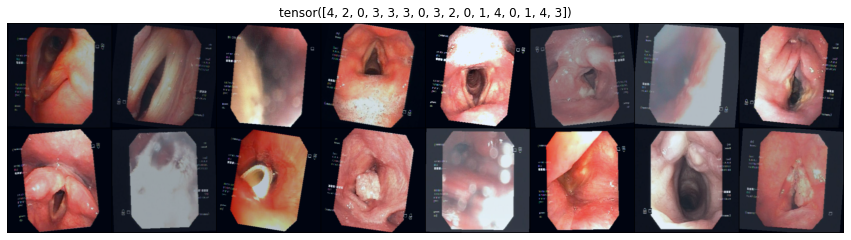

In [21]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(images, labels)

**Define Model**

In [22]:
model = models.inception_v3(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [23]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [24]:
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

In [25]:
import torch.nn.functional as f
#model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.Linear(128, 5)
)

In [ ]:
#model = model.cuda()

In [26]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

**Train Model**

In [27]:
from sklearn import preprocessing
num_epochs = 30
acc_list = [0]
acc = 0
for epoch in range(num_epochs):
    model.train
    total_batch = len(train_data)//batch_size
    total = 0
    correct = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):
      
        #X = batch_images.cuda()
        i = i+1
        X = batch_images
        Y = batch_labels
        #Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(pre.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).float().sum().item()
        
        acc = 100 * correct / total
        acc_list.append(acc)
        if acc_list[i] > acc_list[i-1]:
          torch.save(model.state_dict(), '/content/drive/MyDrive/Multi5Class_VC/Checkpoint/checkpoint.pth')

        #if (i+1) % 20 == 0:
            #print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 #%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    print("Epoch [{}/{}], Loss: {:.4f} Accuracy of the network: {:.4f}%".format(epoch+1, num_epochs, cost.item(), acc))

Epoch [1/30], Loss: 0.8184 Accuracy of the network: 44.5485%
Epoch [2/30], Loss: 0.7549 Accuracy of the network: 53.6344%
Epoch [3/30], Loss: 1.4034 Accuracy of the network: 54.6256%
Epoch [4/30], Loss: 1.1181 Accuracy of the network: 56.2775%
Epoch [5/30], Loss: 0.9041 Accuracy of the network: 56.9934%
Epoch [6/30], Loss: 1.6053 Accuracy of the network: 57.2687%
Epoch [7/30], Loss: 1.2185 Accuracy of the network: 59.2511%
Epoch [8/30], Loss: 1.3208 Accuracy of the network: 60.1872%
Epoch [9/30], Loss: 0.9198 Accuracy of the network: 59.0859%
Epoch [10/30], Loss: 0.4999 Accuracy of the network: 60.8480%
Epoch [11/30], Loss: 1.6129 Accuracy of the network: 60.5176%
Epoch [12/30], Loss: 0.7948 Accuracy of the network: 60.5727%
Epoch [13/30], Loss: 0.9808 Accuracy of the network: 62.0595%
Epoch [14/30], Loss: 0.6751 Accuracy of the network: 59.4714%
Epoch [15/30], Loss: 0.9053 Accuracy of the network: 62.6101%
Epoch [16/30], Loss: 0.7328 Accuracy of the network: 61.7291%
Epoch [17/30], Lo

In [ ]:
'''
if torch.cuda.is_available():
    input_batch = total_batch.to('cuda')
    model.to('cuda')
'''

AttributeError: ignored

**Test Model**

In [30]:
model.eval()

correct = 0
total = 0

for i, (images, labels) in enumerate(test_loader):
    
    #images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum()
    #correct += (predicted == labels.cuda()).sum()
    acc_eval = 100 * float(correct) / total
    
print('Accuracy of test images: %f %%' % (acc_eval))

Accuracy of test images: 58.810573 %


In [ ]:
classes = ['Blu-Img','Non-VC','Nor-VC','Ben-VC','Mag-VC']

In [ ]:
images, labels = iter(test_loader).next()

#outputs = model(images.cuda())
outputs = model(images)

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)